# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import time

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile["became_member_on"].max() # getting the last date a customer has joined in this dataset

20180726

In [5]:
ref_date = datetime.datetime(2018, 7, 26) # using the last date joined as a reference date to compute the customer tenure length

In [6]:
tenure_lengths = []
joined_dates = []
for row in profile.itertuples():
    date = row.became_member_on
    joined_date = datetime.datetime(int(str(date)[0:4]), int(str(date)[4:6]), int(str(date)[6:8]))
    days_delta = ref_date - joined_date
    days_delta = days_delta.days
    tenure_lengths.append(days_delta)
    joined_dates.append(joined_date)
profile["tenure_length"] = tenure_lengths
profile["joined_date"] = joined_dates

In [7]:
profile.drop(["became_member_on"], axis=1, inplace=True)

In [8]:
profile["age"] = profile["age"].replace([118], np.nan)

In [9]:
profile.head()

,age,gender,id,income,tenure_length,joined_date
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04


In [10]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [11]:
web = []
email = []
mobile = []
social = []
for row in portfolio.itertuples():
    if "web" in row.channels:
        web.append(1)
    else:
        web.append(0)
    if "email" in row.channels:
        email.append(1)
    else:
        email.append(0)
    if  "mobile" in row.channels:
        mobile.append(1)
    else:
        mobile.append(0)
    if "social" in row.channels:
        social.append(1)
    else:
        social.append(0)
portfolio["channel_type_web"] = web
portfolio["channel_type_email"] = email
portfolio["channel_type_mobile"] = mobile
portfolio["channel_type_social"] = social

In [12]:
portfolio = pd.get_dummies(portfolio, columns=["offer_type"])

In [13]:
portfolio.drop(["channels"], axis=1, inplace=True)

In [14]:
portfolio.head()

,difficulty,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [15]:
transcript_copy = pd.read_json('data/transcript.json', orient='records', lines=True)

In [16]:
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [17]:
transcript[transcript["event"] == "transaction"]["value"].head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

In [18]:
transcript[transcript["event"] == "offer received"]["value"].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [19]:
transcript[transcript["event"] == "offer viewed"]["value"].head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [20]:
transcript[transcript["event"] == "offer completed"]["value"].head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

The data type of "value" column depends on the "event" values. I'll process them manually.

In [21]:
# lists for dummies
transaction = []
offer_received = []
offer_viewed = []
offer_completed = []

offer_ids= []
transaction_amounts = []
complete_rewards = []

for row in transcript.itertuples():
    event = row.event
    
    if event == "transaction":
        transaction.append(1)
        transaction_amounts.append(row.value.get("amount"))
        
        
        offer_received.append(0)
        offer_viewed.append(0)
        offer_completed.append(0)
        offer_ids.append(None)
        complete_rewards.append(np.nan)

    elif event == "offer received":
        offer_received.append(1)
        offer_ids.append(row.value.get("offer id"))
        
        offer_viewed.append(0)
        offer_completed.append(0)
        transaction.append(0)
        transaction_amounts.append(np.nan)
        complete_rewards.append(np.nan)

    elif event == "offer viewed":
        offer_viewed.append(1)
        offer_ids.append(row.value.get("offer id"))
        
        offer_received.append(0)
        offer_completed.append(0)
        complete_rewards.append(np.nan)
        transaction.append(0)
        transaction_amounts.append(np.nan)
        
    else: # offer complete
        offer_completed.append(1)
        offer_ids.append(row.value.get("offer_id"))
        complete_rewards.append(row.value.get("reward"))
        
        offer_received.append(0)
        offer_viewed.append(0)
        transaction.append(0)
        transaction_amounts.append(np.nan)

transcript["event_type_offer_received"] = offer_received
transcript["event_type_offer_viewed"] = offer_viewed
transcript["event_type_transaction"] = transaction
transcript["event_type_offer_completed"] = offer_completed

transcript["offer_id"] = offer_ids
transcript["transaction_amount"] = transaction_amounts
transcript["reward_amount"] = complete_rewards



In [22]:
transcript.drop(["event", "value"], axis=1, inplace=True)

In [23]:
transcript.head()

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [24]:
# cleaning up rounding errors
transcript["transaction_amount"] = transcript["transaction_amount"].apply(lambda x: round(x, 2))
transcript["reward_amount"] = transcript["reward_amount"].apply(lambda x: round(x, 2))

In [25]:
# Maunually unit testing the transcript df dummies


In [26]:
assert transcript[transcript["event_type_transaction"] == 1]["event_type_transaction"].count() == transcript_copy[transcript_copy["event"] == "transaction"]["event"].count(), "transaction counts are incorrect"
print("transaction test: pass")

assert transcript[transcript["event_type_offer_received"] == 1]["event_type_offer_received"].count() == transcript_copy[transcript_copy["event"] == "offer received"]["event"].count(), "offer received counts are incorrect"
print("offer received test: pass")

transcript[transcript["event_type_offer_viewed"] == 1]["event_type_offer_viewed"].count()  == transcript_copy[transcript_copy["event"] == "offer viewed"]["event"].count(), "offer viewed counts are incorrect"
print("offer viewed test: pass")

transcript[transcript["event_type_offer_completed"] == 1]["event_type_offer_completed"].count()  == transcript_copy[transcript_copy["event"] == "offer completed"]["event"].count(), "offer completed counts are incorrect"
print("offer completed test: pass")


transaction test: pass
offer received test: pass
offer viewed test: pass
offer completed test: pass


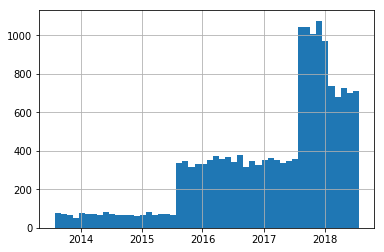

In [27]:
profile["joined_date"].hist(bins=50);

In [28]:
profile_copy = profile.copy()

In [29]:
profile_copy.index = profile_copy["joined_date"]

In [30]:
joined_date_hist = profile_copy.groupby(pd.Grouper(freq='M')).describe()

In [31]:
joined_date_hist.iloc[0:, 0]

joined_date
2013-07-31      5.0
2013-08-31     64.0
2013-09-30     55.0
2013-10-31     53.0
2013-11-30     46.0
2013-12-31     51.0
2014-01-31     62.0
2014-02-28     54.0
2014-03-31     54.0
2014-04-30     61.0
2014-05-31     64.0
2014-06-30     56.0
2014-07-31     54.0
2014-08-31     57.0
2014-09-30     55.0
2014-10-31     47.0
2014-11-30     51.0
2014-12-31     47.0
2015-01-31     61.0
2015-02-28     60.0
2015-03-31     59.0
2015-04-30     58.0
2015-05-31     64.0
2015-06-30     53.0
2015-07-31     64.0
2015-08-31    242.0
2015-09-30    238.0
2015-10-31    233.0
2015-11-30    228.0
2015-12-31    237.0
              ...  
2016-02-29    237.0
2016-03-31    256.0
2016-04-30    266.0
2016-05-31    262.0
2016-06-30    250.0
2016-07-31    271.0
2016-08-31    262.0
2016-09-30    233.0
2016-10-31    253.0
2016-11-30    245.0
2016-12-31    240.0
2017-01-31    250.0
2017-02-28    239.0
2017-03-31    236.0
2017-04-30    252.0
2017-05-31    234.0
2017-06-30    260.0
2017-07-31    345.0
2017-08-

In [32]:
profile.to_csv("profile_datetime.csv")

In [33]:
joined_date_hist.iloc[:, 0].sum()

14825.0

In [34]:
joined_date_hist.iloc[0:25, 0].sum()

1355.0

In [35]:
joined_date_hist.iloc[25:49, 0].sum()

6018.0

In [36]:
joined_date_hist.iloc[50:55, 0].sum()

3718.0

In [37]:
joined_date_hist.iloc[55:, 0].sum()

2964.0

There seems to be abrupt changes in the number of newly joined customers around mid 2015, mid 2017, and early 2018. This might indicate that different numbers of samples were taken from different time frames. We should keep this in mind, especially when we generalize the findings at the end of this study.

In [38]:
profile.columns

Index(['age', 'gender', 'id', 'income', 'tenure_length', 'joined_date'], dtype='object')

In [39]:
profile["tenure_length"].describe()

count    17000.000000
mean       517.449882
std        411.223904
min          0.000000
25%        208.000000
50%        358.000000
75%        791.000000
max       1823.000000
Name: tenure_length, dtype: float64

In [40]:
t1 = time.time()
total_transaction_amounts = []
for row in profile.itertuples():
    total_transaction_amounts.append(transcript[transcript["person"] == row.id]["transaction_amount"].sum())
print(time.time() - t1)

273.63917207717896


In [41]:
profile["total_transaction_amount"] = total_transaction_amounts

In [42]:
total_reward_amounts = []
for row in profile.itertuples():
    total_reward_amounts.append(transcript[transcript["person"] == row.id]["reward_amount"].sum())

In [43]:
profile["total_reward_amount"] = total_reward_amounts

In [44]:
profile.to_csv("profile_processed.csv", index=False)

In [45]:
profile = pd.read_csv("profile_processed.csv")

In [124]:
def compute_successful_discounts_by_type(discount_type, customer_id, transcript=transcript, portfolio=portfolio):
    
    offer_type = discount_type
    successful_offer_ids = []
    successful_offer_idxs = []
    successful_offer_start_times = []
    successful_offer_end_times = []

    df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]

    received_offers = transcript[(transcript["person"] == customer_id) & (transcript["event_type_offer_received"] == 1)]["offer_id"]

    # exclude other offers
    informational_ids = list(portfolio[portfolio["offer_type_informational"] == 1]["id"].values)
    bogo_ids = list(portfolio[portfolio["offer_type_bogo"] == 1]["id"].values)
    discount_ids = list(portfolio[portfolio["offer_type_discount"] == 1]["id"].values)
    print(received_offers)
    # select the specific type of offers only
    if offer_type == "bogo":
        del_offer_ids = informational_ids + discount_ids
    elif offer_type == "discount":
        del_offer_ids = informational_ids + bogo_ids
    elif offer_type == "informational":
        del_offer_ids = discount_ids + bogo_ids

    for offer_id in del_offer_ids:
        received_offers = received_offers.drop(received_offers[received_offers == offer_id].index)
    print(received_offers)
    # remove the redundant offer ids
    received_offers.drop_duplicates(inplace=True)

    received_offer_ids = list(received_offers.values)

    for idx, offer_id in received_offers.items():
        # get a list of time stamps each type of offers were received
        received_time_list = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_received"] == 1)]["time"].values

        # get the length of days the offer is in effect
        offer_effective_days = portfolio[portfolio["id"] == offer_id]["duration"].values[0]

        # for each offers, test if the offer was successful
        for time in received_time_list:
            # calculate the time the offer expires
            offer_start_time = time

            offer_end_time = offer_start_time + offer_effective_days * 24

            # check if the offer was effective
            offer_viewed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_viewed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values

            offer_completed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_completed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values
#             print(offer_start_time, offer_viewed_time, offer_completed_time, offer_end_time)
            if len(offer_viewed_time) > 0 and offer_viewed_time[0] <= offer_end_time and len(offer_completed_time) > 0 and offer_completed_time[0] <= offer_end_time and offer_viewed_time[0] <= offer_completed_time[0]:
                successful_offer_ids.append(offer_id)
                successful_offer_idxs.append(idx)
                successful_offer_start_times.append(offer_start_time)
                successful_offer_end_times.append(offer_end_time)
    
    return successful_offer_ids, successful_offer_idxs, successful_offer_start_times, successful_offer_end_times
    

In [125]:
compute_successful_discounts_by_type("bogo", profile.iloc[8, 2])

5         f19421c1d4aa40978ebb69ca19b0e20d
53179     9b98b8c7a33c4b65b9aebfe6a799e6d9
110831    2906b810c7d4411798c6938adc9daaa5
150601    9b98b8c7a33c4b65b9aebfe6a799e6d9
201577    f19421c1d4aa40978ebb69ca19b0e20d
245126    fafdcd668e3743c1bb461111dcafc2a4
Name: offer_id, dtype: object
5         f19421c1d4aa40978ebb69ca19b0e20d
53179     9b98b8c7a33c4b65b9aebfe6a799e6d9
150601    9b98b8c7a33c4b65b9aebfe6a799e6d9
201577    f19421c1d4aa40978ebb69ca19b0e20d
Name: offer_id, dtype: object


(['f19421c1d4aa40978ebb69ca19b0e20d',
  'f19421c1d4aa40978ebb69ca19b0e20d',
  '9b98b8c7a33c4b65b9aebfe6a799e6d9'],
 [5, 5, 53179],
 [0, 504, 408],
 [120, 624, 576])

In [122]:
transcript[transcript["person"] == profile.iloc[8, 2]]

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount
5,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
12650,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
32625,389bc3fa690240e798340f5a15918d5c,60,0,0,1,0,None,9.54,NaN
32626,389bc3fa690240e798340f5a15918d5c,60,0,0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
53179,389bc3fa690240e798340f5a15918d5c,168,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
77212,389bc3fa690240e798340f5a15918d5c,192,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
110831,389bc3fa690240e798340f5a15918d5c,336,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
132803,389bc3fa690240e798340f5a15918d5c,354,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
150601,389bc3fa690240e798340f5a15918d5c,408,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
179953,389bc3fa690240e798340f5a15918d5c,438,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN


In [123]:
# transcript

In [91]:
customer_id = profile.iloc[10, 2]
offer_type = "discount"
successful_offer_ids = []

df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]

received_offers = transcript[(transcript["person"] == customer_id) & (transcript["event_type_offer_received"] == 1)]["offer_id"]

# exclude other offers
informational_ids = list(portfolio[portfolio["offer_type_informational"] == 1]["id"].values)
bogo_ids = list(portfolio[portfolio["offer_type_bogo"] == 1]["id"].values)
discount_ids = list(portfolio[portfolio["offer_type_discount"] == 1]["id"].values)

# select the specific type of offers only
if offer_type == "bogo":
    del_offer_ids = informational_ids + discount_ids
elif offer_type == "discount":
    del_offer_ids = informational_ids + bogo_ids
else:
    del_offer_ids = discount_ids + bogo_ids

for offer_id in del_offer_ids:
    received_offers = received_offers.drop(received_offers[received_offers == offer_id].index)

# remove the redundant offer ids
received_offers.drop_duplicates(inplace=True)

received_offer_ids = list(received_offers.values)

for idx, offer_id in received_offers.items():
    # get a list of time stamps each type of offers were received
    received_time_list = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_received"] == 1)]["time"].values

    # get the length of days the offer is in effect
    offer_effective_days = portfolio[portfolio["id"] == offer_id]["duration"].values[0]

In [93]:
offer_effective_days

7

In [79]:
        # for each offers, test if the offer was successful
        for time in received_time_list:
            # calculate the time the offer expires
            offer_start_time = time

            offer_end_time = offer_start_time + offer_effective_days * 24

            # check if the offer was effective
            offer_viewed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_viewed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values

            offer_completed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_completed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values

            if len(offer_viewed_time) > 0 and offer_viewed_time[0] <= offer_end_time and len(offer_completed_time) > 0 and offer_completed_time[0] <= offer_end_time and offer_viewed_time[0] <= offer_completed_time[0]:
                successful_offer_ids.append(offer_id)

6         2298d6c36e964ae4a3e7e9706d1fb8c2
110833    2298d6c36e964ae4a3e7e9706d1fb8c2
245127    ae264e3637204a6fb9bb56bc8210ddfd
Name: offer_id, dtype: object

6         2298d6c36e964ae4a3e7e9706d1fb8c2
110833    2298d6c36e964ae4a3e7e9706d1fb8c2
Name: offer_id, dtype: object


In [86]:
for a, b in received_offers:
    print(a, b)

ValueError: too many values to unpack (expected 2)

In [67]:
customer_id

'ae264e3637204a6fb9bb56bc8210ddfd'

In [80]:
offer_id = "2298d6c36e964ae4a3e7e9706d1fb8c2"

In [81]:
received_time_list = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_received"] == 1)]["time"].values

In [82]:
received_time_list

array([  0, 336])

In [45]:
import time
t1 = time.time()
successful_bogo_counts = []
successful_discount_counts = []

for row in profile.itertuples():
    successful_bogo_counts.append(len(compute_successful_discounts_by_type("bogo", row.id)))
    successful_discount_counts.append(len(compute_successful_discounts_by_type("discount", row.id)))
print(time.time() - t1)

1470.7453532218933


In [48]:
profile["successful_bogo_count"] = successful_bogo_counts
profile["successful_discount_count"] = successful_discount_counts

NameError: name 'successful_bogo_counts' is not defined

In [47]:
profile.to_csv("profile_processed2.csv", index=False)

Good until here

work in progress below

TODO: informational offer computation
1: get the customer subset of transcript
2: for BOGO and discount offers, remove transactions that took place during the BOGO/discount offers, and record the time to exclude
3: separate the remaining time frame into the non-promotional and informational time
4: calculate the transaction frequency/amount(?)


In [47]:
profile

,age,gender,id,income,tenure_length,joined_date,total_transaction_amount,total_reward_amount
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,20.40,5.0
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,77.01,5.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,14.30,0.0
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,159.27,20.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,4.65,0.0
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,91,2018-04-26,57.73,7.0
6,NaN,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,304,2017-09-25,0.00,0.0
7,NaN,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,297,2017-10-02,0.24,0.0
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,167,2018-02-09,36.43,19.0
9,NaN,NaN,8974fc5686fe429db53ddde067b88302,NaN,611,2016-11-22,15.62,5.0


In [79]:
profile = pd.read_csv("profile_processed2.csv")

In [133]:
def compute_additional_customer_features(customer_id, transcript=transcript, profile=profile):
    df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]
    
    # get a list of offers a customer has received
    received_offers = transcript[(transcript["person"] == customer_id) & (transcript["event_type_offer_received"] == 1)]["offer_id"]
    
    # convert the received_offers to the transcript index and the corresponding offer ids
    received_offer_idxs = list(received_offers.index)
    received_offer_ids = list(received_offers.values)
    
    offer_time_list = [[], [], []] # a list of lists to record when discount and bogo offers were in effect, the first list contains the beginning time, and the second list contains the ending time, and the last contains the type of offer (informational or discount/bogo)

    for idx, offer_id in received_offers.items():
        offer_start_time = transcript.iloc[idx, 1]
        offer_effective_days = portfolio[portfolio["id"] == offer_id]["duration"].values[0]
        offer_end_time = offer_start_time + offer_effective_days * 24
        offer_time_list[0].append(offer_start_time)
        offer_time_list[1].append(offer_end_time)

        informational_ids = list(portfolio[portfolio["offer_type_informational"] == 1]["id"].values)
        bogo_ids = list(portfolio[portfolio["offer_type_bogo"] == 1]["id"].values)

        if offer_id in informational_ids:
            offer_time_list[2].append("informational")
        elif offer_id in bogo_ids:
            offer_time_list[2].append("bogo")
        else:
            offer_time_list[2].append("discount")

    # create a time table to fill when offers were in effect
    number_of_days = 30
    duration_hours = number_of_days * 24
    df_timetable = pd.DataFrame(0, index=np.arange(duration_hours), columns=["discount", "bogo", "informational", "no_promotions", "transaction", "transaction_amount"])

    # record the discount, bogo, informational offers in effect
    for i in range(len(offer_time_list[0])):
        offer_type = offer_time_list[2][i]
        start_time = offer_time_list[0][i]
        end_time = offer_time_list[1][i]
        if offer_type == "discount":
            df_timetable.iloc[start_time:end_time, 0] += 1
        elif offer_type == "bogo":
            df_timetable.iloc[start_time:end_time, 1] += 1
        else:
            df_timetable.iloc[start_time:end_time, 2] += 1
    
    # calculate when there were no offers in effect
    df_timetable["no_promotions"] = np.where(((df_timetable["discount"] + df_timetable["bogo"] + df_timetable["informational"]) == 0), 1, 0)
    
    # add the customer's transaction history and amount
    transaction_time = df_single_customer_transcript[df_single_customer_transcript["event_type_transaction"] == 1]["time"].values
    transaction_amount = df_single_customer_transcript[df_single_customer_transcript["event_type_transaction"] == 1]["transaction_amount"].values
    
    for i in range(len(transaction_time)):
        df_timetable.iloc[transaction_time[i], 4] = 1
        df_timetable.iloc[transaction_time[i], 5] = transaction_amount[i]
#     print(df_timetable)
    # calculate new feature values
    hours_discount = df_timetable[(df_timetable["discount"] > 0)]["discount"].count()
    hours_bogo = df_timetable[(df_timetable["bogo"] > 0)]["bogo"].count()
    hours_informational = df_timetable[(df_timetable["informational"] > 0)]["informational"].count()
    hours_no_promotions = df_timetable[(df_timetable["no_promotions"] > 0)]["no_promotions"].count()
    discount_transaction_counts = df_timetable[(df_timetable["discount"] > 0) & (df_timetable["transaction"] == 1)]["discount"].count()
    bogo_transaction_counts = df_timetable[(df_timetable["bogo"] > 0) & (df_timetable["transaction"] == 1)]["bogo"].count()
    informational_transaction_counts = df_timetable[(df_timetable["informational"] > 0) & (df_timetable["transaction"] == 1)]["informational"].count()
    no_promotions_transaction_counts = df_timetable[(df_timetable["no_promotions"] > 0) & (df_timetable["transaction"] == 1)]["no_promotions"].count()
    discount_transaction_amount = df_timetable[(df_timetable["discount"] > 0) & (df_timetable["transaction"] == 1)]["transaction_amount"].sum()
    bogo_transaction_amount = df_timetable[(df_timetable["bogo"] > 0) & (df_timetable["transaction"] == 1)]["transaction_amount"].sum()
    informational_transaction_amount = df_timetable[(df_timetable["informational"] > 0) & (df_timetable["transaction"] == 1)]["transaction_amount"].sum()
    no_promotions_transaction_amount = df_timetable[(df_timetable["no_promotions"] > 0) & (df_timetable["transaction"] == 1)]["transaction_amount"].sum()
    overlap_hours = df_timetable[((df_timetable["discount"] + df_timetable["bogo"]) > 1)]["discount"].count()
    max_overlap = (df_timetable["discount"] + df_timetable["bogo"]).max()
    
    if hours_discount != 0:
        avg_spending_discount = discount_transaction_amount / hours_discount
    else:
        avg_spending_discount = np.nan
    
    if hours_bogo != 0:
        avg_spending_bogo = bogo_transaction_amount / hours_bogo
    else:
        avg_spending_bogo = np.nan
    
    if hours_informational != 0:
        avg_spending_informational = informational_transaction_amount / hours_informational
    else:
        avg_spending_informational = np.nan
        
    if hours_no_promotions != 0:
        avg_spending_no_promotions = no_promotions_transaction_amount / hours_no_promotions
    else:
        avg_spending_no_promotions = np.nan
    
    return hours_discount, hours_bogo, hours_informational, hours_no_promotions, discount_transaction_counts, bogo_transaction_counts, informational_transaction_counts, no_promotions_transaction_counts, discount_transaction_amount, bogo_transaction_amount, informational_transaction_amount, no_promotions_transaction_amount, overlap_hours, max_overlap, avg_spending_discount, avg_spending_bogo, avg_spending_informational, avg_spending_no_promotions

In [138]:
test_df = profile.iloc[0:100]

In [142]:
t1 = time.time()
for row in test_df.itertuples():

    days_discount, days_bogo, days_informational, days_no_promotions, discount_transaction_counts, bogo_transaction_counts, informational_transaction_counts, no_promotions_transaction_counts, discout_transaction_amount, bogo_transaction_amount, informational_transaction_amount, no_promotions_transaction_amount, overlap_days, max_overlap, avg_spending_discount, avg_spending_bogo, avg_spending_informational, avg_spending_no_promotions = compute_additional_customer_features(row.id)
    print("******************\n")
    print(row.id)
#     print("hours discount: {}".format(days_discount))
#     print("hours bogo: {}".format(days_bogo))
#     print("hours info: {}".format(days_informational))
#     print("hours no promo: {}".format(days_no_promotions))
#     print("discount counts: {}".format(discount_transaction_counts))
#     print("bogo counts: {}".format(bogo_transaction_counts))
#     print("info counts: {}".format(informational_transaction_counts))
#     print("no promo counts: {}".format(no_promotions_transaction_counts))
#     print("disc amount: {}".format(discout_transaction_amount))
#     print("bogo amount: {}".format(bogo_transaction_amount))
#     print("info amount: {}".format(informational_transaction_amount))
#     print("no promo amount: {}".format(no_promotions_transaction_amount))
#     print("overlap hours: {}".format(overlap_days))
#     print("max overlap: {}".format(max_overlap))
    print("avg disc amount: {}".format(round(avg_spending_discount,2)))
    print("avg bogo amount: {}".format(round(avg_spending_bogo, 2)))
    print("avg info amount: {}".format(round(avg_spending_informational, 2)))
    print("avg no promo amount: {}".format(round(avg_spending_no_promotions, 2)))
    print("")
print(time.time() - t1)

******************

68be06ca386d4c31939f3a4f0e3dd783
avg disc amount: 0.04
avg bogo amount: nan
avg info amount: nan
avg no promo amount: 0.0

******************

0610b486422d4921ae7d2bf64640c50b
avg disc amount: nan
avg bogo amount: 0.14
avg info amount: 0.24
avg no promo amount: 0.1

******************

38fe809add3b4fcf9315a9694bb96ff5
avg disc amount: nan
avg bogo amount: 0.0
avg info amount: 0.03
avg no promo amount: 0.03

******************

78afa995795e4d85b5d9ceeca43f5fef
avg disc amount: nan
avg bogo amount: 0.22
avg info amount: 0.27
avg no promo amount: 0.2

******************

a03223e636434f42ac4c3df47e8bac43
avg disc amount: 0.0
avg bogo amount: nan
avg info amount: 0.0
avg no promo amount: 0.03

******************

e2127556f4f64592b11af22de27a7932
avg disc amount: 0.05
avg bogo amount: 0.11
avg info amount: 0.0
avg no promo amount: 0.23

******************

8ec6ce2a7e7949b1bf142def7d0e0586
avg disc amount: 0.0
avg bogo amount: 0.0
avg info amount: 0.0
avg no promo amount: 

******************

b7a66e629b134079a9bc7120c7b9947b
avg disc amount: 0.33
avg bogo amount: 0.18
avg info amount: nan
avg no promo amount: 0.08

******************

ca82e1ebc759402c8ab95c341755bdf1
avg disc amount: 0.25
avg bogo amount: 0.08
avg info amount: nan
avg no promo amount: 0.05

******************

54890f68699049c2a04d415abc25e717
avg disc amount: 0.16
avg bogo amount: nan
avg info amount: 0.11
avg no promo amount: 0.17

******************

ab66a363907e43e9a7cd535f1578245b
avg disc amount: 0.06
avg bogo amount: 0.03
avg info amount: 0.0
avg no promo amount: 0.02

******************

d3f146b615514c6380b168bb3df5f05b
avg disc amount: 0.2
avg bogo amount: 0.31
avg info amount: nan
avg no promo amount: 0.13

******************

a5a6ef2b78a04ddc9f374dd7c7f60bff
avg disc amount: 0.51
avg bogo amount: 0.29
avg info amount: 0.19
avg no promo amount: 0.08

******************

2e87ba0fba1a4d1a8614af771f07a94d
avg disc amount: 0.32
avg bogo amount: 0.23
avg info amount: 0.63
avg no prom